In [405]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8, 8]

from faker import Factory
from itertools import islice
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

import pyodbc
import pysal as ps

from pysal.viz.mapclassify import Natural_Breaks as nb

from math import log10
from shapely.geometry import Point
from shapely import wkt

from IPython.display import IFrame

import folium
from folium.plugins import HeatMap

fake = Factory.create()

In [406]:
conn = pyodbc.connect('DSN=GEODWH;UID=GEODWH_READ;PWD=readonly')
ss_select = "SELECT [RPT_ID],[RIN],[RPT_TYPE],[SAMPLEID],[SAMPCODE],[FILE_ID],[LAT94],[LNG94],[As_ppm],[Au_ppm] FROM [GEODWH].[dbo].[ASSAY_SURFSAMP_TRACE] WHERE [LNG94] > 140 and [LNG94] < 142 and [LAT94] > -32.5 and [LAT94] < -31 and SAMPCODE in ('SOIL', 'AUGER', 'SURF_DRILL', 'LAG', 'FLOAT', 'UNKNOWN','VEGETATION')"
dh_select = "SELECT [RPT_ID],[RIN],[RPT_TYPE],[HOLEID] AS SAMPLEID,[DRILLCODE] AS SAMPCODE,[ASSAY_FILE_ID] AS FILEID,[LAT94],[LNG94],[As_ppm],[Au_ppm] FROM [GEODWH].[dbo].[ASSAY_MAX_DRILL_TRACE] WHERE DRILLCODE in ('AUGER', 'VAC', 'SURF_DRILL', 'VIB', 'AUG') and [LNG94] > 140 and [LNG94] < 142 and [LAT94] > -32.5 and [LAT94] < -31"

# Read the Auger samples from the drillhole table
# We only use : 'SOIL', 'AUGER', 'SURF_DRILL', 'LAG', 'FLOAT', 'UNKNOWN','VEGETATION'
drillholes = pd.read_sql(dh_select, conn)

In [407]:
# Check unique sample codes
dhtypes = drillholes['SAMPCODE'].unique()
drillholes['SAMPCODE'].replace('AUG', 'AUGER', inplace=True) # Fix a namecase
drillholes['SAMPCODE'].replace('Auger', 'AUGER', inplace=True) # Fix a namecase

# Read the Surface samples from the drillhole table
ss = pd.read_sql(ss_select, conn)
ss['SAMPCODE'] = ss['SAMPCODE'].map(lambda x: x.strip())# Fix some whitespaces
ss['RIN'] = ss['RIN'].map(lambda x: x.strip())
ss['RPT_TYPE'] = ss['RPT_TYPE'].map(lambda x: x.strip())
ss['SAMPLEID'] = ss['SAMPLEID'].map(lambda x: x.strip())
ss['SAMPCODE'].replace('Soil', 'SOIL', inplace=True)

# Combine
samples = ss.append(drillholes)

# Check unique sample codes
stypes = samples['SAMPCODE'].unique()
stypes.sort()

print(f'Sample types: {stypes}')
print(len(samples))

Sample types: ['AUGER' 'FLOAT' 'LAG' 'SOIL' 'SURF_DRILL' 'UNKNOWN' 'VEGETATION']
54127


In [408]:
# Make geometry field wkt (Well Known Text)
samples['Coordinates'] = list(zip(samples.LNG94.round(6), samples.LAT94.round(6))) # Round to 6dp
samples['Coordinates'] = samples['Coordinates'].apply(Point)
samples = gpd.GeoDataFrame(samples, geometry='Coordinates', crs={'init' :'epsg:4283'})

In [410]:
# Pickle it
filepath = 'broken_hill_surface_samples_201900408.pickle'

# DUMP
with open(filepath, 'wb') as f:
    pickle.dump(points, f, pickle.HIGHEST_PROTOCOL)
    
# OPEN
# with open('broken_hill_surface_samples.pickle', 'rb') as f:
#     pickled_points = pickle.load(f)

<IPython.core.display.Javascript object>


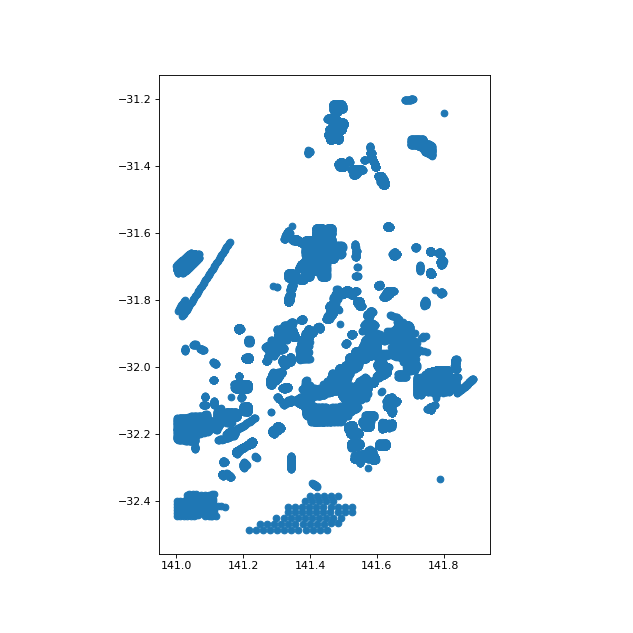

In [418]:
# Take a look
samples.plot()

In [412]:
# Function to Buffer the points

def buffer(data, distance=0.0075, resolution=10):
    """
    Buffer points to return polygons of spatially distinct data sets.
    
    params:
        data: GeoDataFrame
    returns:
        buffer_union: GeoDataFrame of buffers
    """
    
    buffers = data.buffer(distance, resolution)
    buffer_union = buffers.unary_union
    return buffer_union

In [413]:
# Function to convert the single buffer polygons to a GeoDataFrame

def sb_attributes(singlebuffer):
    """
    Converts wkt polygon to GeoDataFrame
    
    params:
        wkt: Polygon
    returns:
        GeoDataFrame
    """
    colour = fake.hex_color()
    
    # Set a dictonary to build the attributes for the polygon
    sb_attributes = dict()
    sb_attributes['geometry'] = singlebuffer
    sb_attributes['index'] = [0]
    sb_attributes['stroke'] = [colour]
    # TODO add the RIN as a tooltip
    
    # Covert the dictionary into the GeoDataFrame 
    sb_attributes_df = pd.DataFrame(sb_attributes)
    sb_attributes_gdf = gpd.GeoDataFrame(sb_attributes_df)
    sb_attributes_gdf.columns={'geometry': 'geometry', 'index': 'index', 'stroke': 'stroke'}
    sb_attributes_gdf.crs = {'init' :'epsg:4326'}
    
    return sb_attributes_gdf

In [414]:
# Function to convert the multi buffers polygons to a GeoDataFrame

def mb_attributes(multibuffer):
        """
        Converts wkt MultiPolygon to GeoDataFrame

        params:
            wkt: MultiPolygon
        returns:
            GeoDataFrame
        """
        # Set a dictonary to build the attributes for each polygon
        mb_attributes = dict()
        geometry = []
        index = []
        stroke = []
    
        # Loop over each polygon in the MultiPolygon
        for idx, b in enumerate(multibuffer):
            colour = fake.hex_color()
            stroke.append(colour)
            geometry.append(b)
            index.append(idx)
            # TODO add the RIN as a tooltip

            # Populate the dictionary
            mb_attributes['geometry'] = geometry
            mb_attributes['index'] = index
            mb_attributes['stroke'] = stroke
            
        # Covert the dictionary into the GeoDataFrame 
        mb_attributes_df = pd.DataFrame(mb_attributes)
        mb_attributes_gdf = gpd.GeoDataFrame(mb_attributes_df)
        mb_attributes_gdf.columns={'geometry': 'geometry', 'index': 'index', 'stroke': 'stroke'}
        mb_attributes_gdf.crs = {'init' :'epsg:4326'}
        
        return mb_attributes_gdf

In [415]:
# Function to join the points to the buffers

def rin_stype_buffered(points, buffers):
    """
    Spatially join points to buffers

    params:
        points: GeoDataFrame containing Points
        buffers: GeoDataFrame containing Points
    returns:
        Combined GeoDataFrame of points and buffers
    """
    points_buffered = gpd.sjoin(points, buffers, how="inner", op='intersects')
    points_buffered.drop(['index_right'], axis=1)
    return points_buffered

In [416]:
# Peep at the head of the DataFrame
print(f'\nSample count : {len(points)}\n')
print(samples.head())


Sample count : 53878

   As_ppm  Au_ppm  FILEID  FILE_ID      LAT94       LNG94        RIN  RPT_ID  \
0    17.5   0.053     NaN    286.0 -31.894562  141.662174  R00029271      28   
1    22.5   0.141     NaN    286.0 -31.894508  141.662132  R00029271      28   
2    19.0   0.027     NaN    286.0 -31.894436  141.662078  R00029271      28   
3    12.5   0.014     NaN    286.0 -31.894374  141.662036  R00029271      28   
4    38.0   0.006     NaN    286.0 -31.894302  141.662003  R00029271      28   

  RPT_TYPE SAMPCODE SAMPLEID                    Coordinates  
0        A     SOIL   372776  POINT (141.662174 -31.894562)  
1        A     SOIL   372777  POINT (141.662132 -31.894508)  
2        A     SOIL   372778  POINT (141.662078 -31.894436)  
3        A     SOIL   372779  POINT (141.662036 -31.894374)  
4        A     SOIL   372780  POINT (141.662003 -31.894302)  


count    27697.000000
mean        -0.104887
std         10.418087
min      -1000.000000
25%          0.000500
50%          0.001590
75%          0.003000
max         76.900002
Name: Au_ppm, dtype: float64


<IPython.core.display.Javascript object>


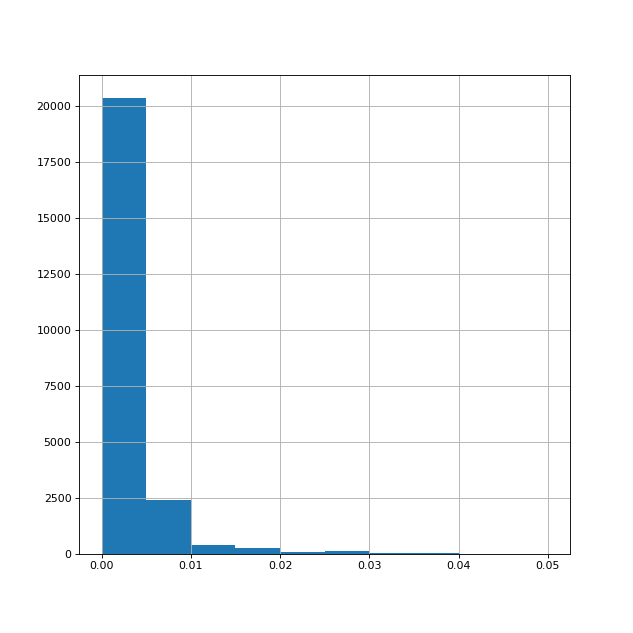

In [419]:
# Peep at the gold stats
print(samples['Au_ppm'].describe())
samples['Au_ppm'].hist(range = (0,0.05))

In [420]:
# Generator function to subdivide the samples according to rin and sampletype

def data_divisions(rins):
    """Divide the data
    
    params:
        Groupby object of samples grouped by rin
    returns:
        yields a tuple (rin, sampleType, sampleData)"""
    # For each rin...
    for rin, rindata in rins:
        stypes = rindata.groupby(['SAMPCODE'])
        
        # For each sample type...
        for stype, rin_stype_data in stypes:
            yield (rin, stype, rin_stype_data)

In [424]:
# Sort by the rins
samples.sort_values('RIN')

# Groupby the rin
rins = samples.groupby(['RIN'])

# Empty frames to collect the buffers and processed samples
all_buffers = gpd.GeoDataFrame()
sbuffered_samples = gpd.GeoDataFrame()
mbuffered_samples = gpd.GeoDataFrame()
all_buffered_samples = gpd.GeoDataFrame()

# Counter to check the output is valid


In [427]:
assert len(all_buffers) == 0
assert len(sbuffered_samples) == 0
assert len(mbuffered_samples) == 0
assert len(all_buffered_samples) == 0

len(samples)

54127

In [428]:
# reset the temp counter
total_samples = 0

# Loop over the samples grouped by the rins and yield the subdivisions
for rin, stype, subsamples in data_divisions(rins):
    
    # We buffer all the samples
    buffers = buffer(subsamples)
    
    print(rin, stype, len(subsamples), buffers.geom_type)
    
    total_samples = total_samples + len(subsamples)
    if buffers.geom_type == 'Polygon':
        
        # For each of the single wkt polygons convert to a dataframe (adding attributes)
        _df = sb_attributes(buffers)
        assert isinstance(_df, gpd.GeoDataFrame)

        # Aggregate the buffers
        all_buffers = gpd.GeoDataFrame(pd.concat([all_buffers, _df], ignore_index=True))
        
        # Spatial join the samples to the buffer
        sbuffered_samples = gpd.sjoin(_df, subsamples, how="inner", op='intersects')
        
        # Aggregate the samples
        all_buffered_samples = gpd.GeoDataFrame(pd.concat([all_buffered_samples, sbuffered_samples], ignore_index=True))

    if buffers.geom_type == 'MultiPolygon':
        
        # Split the Multipolygon wkt to dataframe
        _mdf = mb_attributes(buffers)

        # Set empty frames to collect the subdivided sets
        multisamples = gpd.GeoDataFrame()
        mbuffers = gpd.GeoDataFrame()
        
        # Iterate over the multi-buffer dataframe
        for row, mbuffer in _mdf.groupby('index'):
            assert isinstance(mbuffer, gpd.GeoDataFrame)

            # Aggregate the buffers
            mbuffers = gpd.GeoDataFrame(pd.concat([mbuffers, mbuffer], ignore_index=True))
            
            # Spatially join the samples to the buffers
            mbuffered_samples = gpd.sjoin(mbuffer, subsamples, how="inner", op='intersects')
            
            # Aggregate the samples
            multisamples = gpd.GeoDataFrame(pd.concat([multisamples, mbuffered_samples], ignore_index=True))
        
        # Aggregate the single and multipolygon buffers and samples
        all_buffers = gpd.GeoDataFrame(pd.concat([all_buffers, mbuffers], ignore_index=True))
        all_buffered_samples = gpd.GeoDataFrame(pd.concat([all_buffered_samples, multisamples], ignore_index=True))
        
        # Watch it grow
        print(f'\nCaptured samples: {total_samples} of {len(samples)}\n')

R00000311  AUGER 185 MultiPolygon

Captured samples: 185 of 54127

R00000385  AUGER 130 Polygon
R00000655  AUGER 118 MultiPolygon

Captured samples: 433 of 54127

R00001290  AUGER 59 MultiPolygon

Captured samples: 492 of 54127

R00001912  AUGER 258 Polygon
R00003080  AUGER 100 Polygon
R00009893  AUGER 119 MultiPolygon

Captured samples: 969 of 54127

R00009949  AUGER 1137 MultiPolygon

Captured samples: 2106 of 54127

R00010592  AUGER 94 Polygon
R00010917  AUGER 1280 Polygon
R00011099  AUGER 692 Polygon
R00011227  AUGER 52 Polygon
R00011273  AUGER 750 MultiPolygon

Captured samples: 4974 of 54127

R00013003  AUGER 63 Polygon
R00013348  AUGER 924 Polygon
R00014946  AUGER 607 Polygon
R00015848  AUGER 84 Polygon
R00015905  AUGER 189 Polygon
R00015994  AUGER 198 Polygon
R00016273  AUGER 809 MultiPolygon

Captured samples: 7848 of 54127

R00016285  AUGER 205 Polygon
R00016482  AUGER 147 Polygon
R00016497  AUGER 307 Polygon
R00016498  AUGER 1327 Polygon
R00016528  AUGER 735 Polygon
R0001653

In [429]:
all_buffers.to_file('ALL_BUFFERS_20190408.geojson', driver = "GeoJSON")

c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


class fix_data(object):
    """"""
    def __init__(self, df, element):
        self.df = df
        self.element = element
    
    def force_numeric(self):
        # Coerce element to numeric values
        self.df[self.element].fillna(0, inplace=True)
        # Coerce element to numeric values
        self.df[f'{self.element}_nn'] = pd.to_numeric(self.df[self.element])

    def neg_conversions(self, x):
        # Define the negative conversions
        if x < -5:
            return 0.0005
        if x < 0:
            return abs(x)/2
        if x == 0:
            return 0.0005
        if x > 0:
            return x
        
    def fix_neg(self):
        self.df[f'{self.element}_fn'] = self.df[self.element].apply(lambda x: self.neg_conversions(x))

    def log(self):
        self.df[f'{self.element}_log'] = self.df[f'{self.element}_fn'].apply(lambda x: log10(x))
        
    def threshold(self):
        median = self.df[f'{self.element}_log'].median()
        # Mean Absolute Deviation: Tukey, J.W., 1977. Exploratory Data Analysis. Addison-Wesley, Reading, 688 pp
        mad = self.df[f'{self.element}_log'].mad()  
        # Set threshold: http://crcleme.org.au/Pubs/guides/gawler/a7_id_anomalies.pdf
        self.threshold = median + 2*mad 
        
    def scaling(self, x):
        # Normalisation of values between 0 and 1
        min_value = self.df[f'{self.element}_log'].min()
        x = (x - min_value) / (self.threshold - min_value) # 'Max' value is the threshold 
        return x
        
    def apply_scaling(self):
        self.df['normalised'] = self.df[f'{self.element}_log'].apply(lambda x: self.scaling(x))

    def natural_breaks(self):
        # Apply hex colours to natural breaks
        classifier = nb(self.df[self.element], 7) # nb are natural breaks
        self.df['classifications'] = self.df[self.element].apply(classifier)
        self.df.classifications.replace([1,2,3,4,5,6,7], ['#82817d','#55b1d9','#5bd955','#e6a94e','#e02d2d','#da2de0','#af00b5'], inplace=True)
        

In [352]:
stats_dict = dict()

In [353]:
def boxplots(stats_dict, rin, samples):
    vals = samples[f'{element}'].values
    boxplot = mpl.pyplot.boxplot(vals)
    stats_dict[rin] = boxplot
    return stats_dict

In [287]:
normalised = gpd.GeoDataFrame()

for subset, points in all_buffered_points.groupby(['RIN','index']):
    fd = fix_data(points, 'Au_ppm')
    fd.force_numeric()
    fd.fix_neg()
    fd.log()
    fd.threshold()
    fd.apply_scaling()
    fd.natural_breaks()
    print(len(normalised))
    normalised = gpd.GeoDataFrame(pd.concat([normalised, points], ignore_index=True))
    

c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

0
62


c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pysal\viz\mapclassify\classifiers.py:1429: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % uvk, UserWarning)


185


c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pysal\viz\mapclassify\classifiers.py:1429: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % uvk, UserWarning)
c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pysal\viz\mapclassify\classifiers.py:704: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


315
354
407
433
441
492
750
850
875
969
997
2106
2200
3480
4172
4224
4323
4720
4974
5037
5961
6568
6652
6841
7039
7219
7848
8053
8200
8507
9834
10569
10746
11027
11420
11590
11995
12473
12542
12823
15058
15173
15875
17904
18080
18361
18362
18363
18424
18467
18468
18469
18470
18657
18779
18798
18839


c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pysal\viz\mapclassify\classifiers.py:1429: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % uvk, UserWarning)


20564
21328
21366
21395
21617
21631
21633
21635
21637


c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\pysal\viz\mapclassify\classifiers.py:1429: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % uvk, UserWarning)


21648
21653
21694
21717
21741
21785
22179
22184
22824
22826
22831
22835
22878
22902
22924
22974
22988
23233
23242
23259
23272
23289
23304
23332
23362
23376
23391
23411
23639
23673
23718
24088
24184
24296
24496
29559
29987
29988
30269
30317
30629
31071
31269
31309
31485
31518
31543
31547
31972
32448
32631
32633
32639
32684
32786
32930
32934
32967
33119
33178
33246
34871
34908
34989
35061
35283
35547
35574
35577
35579
35584
35585
35605
35809
35810
36382
36383
36399
36503
36628
36838
36946
37236
37283
37347
37486
37764
37809
37830
37914
37971
38003
38101
38153
38233
38452
38940
39032
39033
39046
39049
39259
39337
39341
39621
40036
40485
40490
40641
40644
40655
40709
40731
41011
41114
41423
43472
43694
45522
45590
45952
46001
46151
46158
46163
46187
46237
46289
46346
46412
46436
46774
46787
46811
47149
47166
47183
47246
47315
47316
47317
47357
47381
47562
48069
48257
48264
48856
49131
50048
52019
52820
53331


In [288]:
list(normalised)

['geometry',
 'index',
 'stroke',
 'index_right',
 'As_ppm',
 'Au_ppm',
 'FILEID',
 'FILE_ID',
 'LAT94',
 'LNG94',
 'RIN',
 'RPT_ID',
 'RPT_TYPE',
 'SAMPCODE',
 'SAMPLEID',
 'Au_ppm_nn',
 'Au_ppm_fn',
 'Au_ppm_log',
 'normalised',
 'classifications']

In [289]:
normalised.head()

,geometry,index,stroke,index_right,As_ppm,Au_ppm,FILEID,FILE_ID,LAT94,LNG94,RIN,RPT_ID,RPT_TYPE,SAMPCODE,SAMPLEID,Au_ppm_nn,Au_ppm_fn,Au_ppm_log,normalised,classifications
0,POLYGON ((141.6843945183655 -31.96889239042095...,0,#56a2ab,1528,3.0,-0.01,8769.0,NaN,-31.964913,141.678064,R00000311,10269,A,AUGER,756135,-0.01,0.005,-2.30103,0.00000,[0]
1,POLYGON ((141.6843945183655 -31.96889239042095...,0,#56a2ab,1527,4.0,-0.01,8769.0,NaN,-31.964815,141.677894,R00000311,10269,A,AUGER,756134,-0.01,0.005,-2.30103,0.00000,[0]
2,POLYGON ((141.6843945183655 -31.96889239042095...,0,#56a2ab,1526,1.0,-0.01,8769.0,NaN,-31.964707,141.677713,R00000311,10269,A,AUGER,756133,-0.01,0.005,-2.30103,0.00000,[0]
3,POLYGON ((141.6843945183655 -31.96889239042095...,0,#56a2ab,1525,1.0,-0.01,8769.0,NaN,-31.964609,141.677543,R00000311,10269,A,AUGER,756132,-0.01,0.005,-2.30103,0.00000,[0]
4,POLYGON ((141.6843945183655 -31.96889239042095...,0,#56a2ab,1524,7.0,0.02,8769.0,NaN,-31.964502,141.677362,R00000311,10269,A,AUGER,756131,0.02,0.020,-1.69897,0.99907,#82817d


In [290]:
_gdf = gpd.GeoDataFrame(normalised, crs={'init' :'epsg:4283'})

norm = _gdf[['RIN', 'SAMPCODE', 'index', 'LAT94', 'LNG94', 'Au_ppm', 'normalised', 'classifications', 'stroke']]

norm['normalised'].fillna(0, inplace=True)
norm['classifications'].replace([0], '#82817d', inplace=True)

norm['Coords'] = list(zip(norm.LNG94.round(6), norm.LAT94.round(6)))
norm['Coords'] = norm['Coords'].apply(Point)

c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


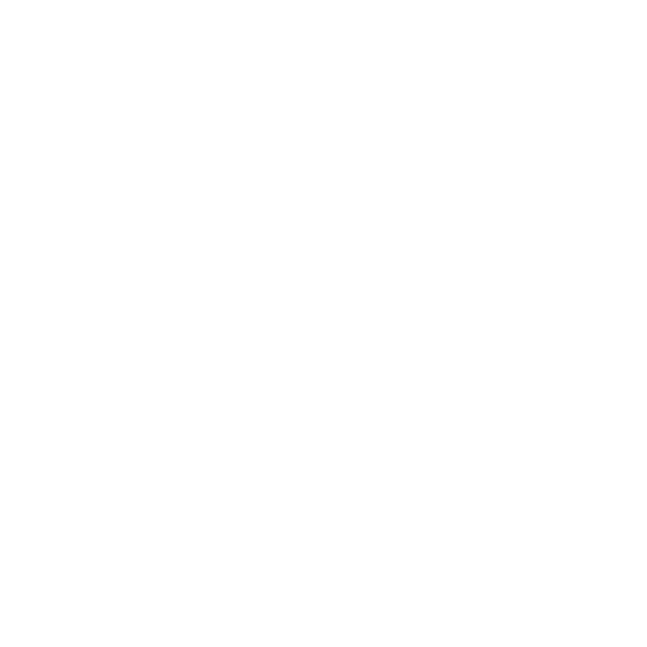

IndexError: too many indices for array

In [296]:
list(normalised)

In [291]:
samples = list(zip(norm.LAT94.values, norm.LNG94.values, norm.normalised.values, norm.classifications.values))

In [292]:
samples

[(-31.964912910863685, 141.67806396675226, 0.0, '#82817d'),
 (-31.964814581998738, 141.67789392180322, 0.0, '#82817d'),
 (-31.96470728819039, 141.6777132287226, 0.0, '#82817d'),
 (-31.964608958835708, 141.67754318452037, 0.0, '#82817d'),
 (-31.964501664506617, 141.6773624922441, 0.9990698045697118, '#82817d'),
 (-31.964403334662208, 141.67719244878865, 0.0, '#82817d'),
 (-31.964296039812403, 141.67701175731673, 0.9990698045697118, '#82817d'),
 (-31.96419770947828, 141.6768417146081, 0.9990698045697118, '#82817d'),
 (-31.964090414107766, 141.67666102394045, 0.9990698045697118, '#82817d'),
 (-31.963992083283934, 141.6764909819786, 0.0, '#82817d'),
 (-31.96389375222276, 141.67632094037626, 0.9990698045697118, '#82817d'),
 (-31.9637864560792, 141.67614025090018, 0.0, '#82817d'),
 (-31.96368812452834, 141.67597021004462, 0.0, '#82817d'),
 (-31.963580827864106, 141.67578952137288, 0.0, '#82817d'),
 (-31.96348249582357, 141.6756194812641, 0.0, '#82817d'),
 (-31.963426868165172, 141.6792806073

In [297]:
# Show me the buffers !!!!
m = folium.Map(location=[-32, 141.5], zoom_start=9)

samples = folium.FeatureGroup(name="samples")

sample_points = list(zip(norm.LAT94.values, norm.LNG94.values, norm.normalised.values, norm.classifications.values))

for lat, lng, au, colour in sample_points:
    samples.add_child(folium.CircleMarker(location=[lat, lng ], radius=1,
        popup=str(au), 
        tooltip=str(au),
        fill=True,  # Set fill to True
        color=str(colour),
        fill_opacity=0.5)).add_to(m)

folium.GeoJson('ALL_BUFFERS.geojson',
    style_function=lambda x: {
        'color' : 'grey',
        'weight' : 2,
        'opacity': 0.66,
        'fillColor' : x['properties']['stroke'],
        }).add_to(m)

# m.add_child(samples)
m.add_child(folium.LayerControl())
m.save("ALL_SAMPLES.html")

# IFrame(src='ALL_SAMPLES.html', width=1000, height=600)

In [256]:
subsets = all_buffered_points.groupby(['RIN','index'])

def apply_normalisation(subset):
    fd = fix_data(subset, 'Au_ppm')
    fd.force_numeric()
    fd.fix_neg()
    fd.log()
    fd.threshold()
    fd.apply_scaling()
    fd.natural_breaks()

normalised = subsets.apply(apply_normalisation)

SyntaxError: 'break' outside loop (cell_name, line 14)

In [93]:
all_buffers.to_file('all_buffers.geojson', driver='GeoJSON')

c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [114]:
list(all_buffers)

['geometry', 'index', 'stroke']

In [146]:
# Join the points to the buffers

buffered_points = gpd.sjoin(all_buffers, points, how="inner", op='intersects')

c:\users\gatesk\appdata\local\programs\python\python36\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


141657

In [ ]:
subsets = all_buffered_points.groupby(['RIN','index'])

def apply_normalisation(subset):
    fd = fix_data(subset, 'Au_ppm')
    fd.force_numeric()
    fd.fix_neg()
    fd.log()
    fd.threshold()
    fd.apply_scaling()
    fd.natural_breaks()

normalised = subsets.apply(apply_normalisation)